# Spectral clustering

- Networkx: https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html
- Tutorial displaying graphs in notebooks: https://ipython-books.github.io/64-visualizing-a-networkx-graph-in-the-notebook-with-d3js/
- Sklearn toy dataset generator: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons
- Kaggle data set: https://www.kaggle.com/piotrgrabo/breastcancerproteomes
- Kaggle example preparing data for clustering: https://www.kaggle.com/piotrgrabo/kmeans-example/code
- Tutorial on spectral clustering: http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf

In [513]:
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from numpy import random
from sklearn import metrics
from seaborn import heatmap
from sklearn.calibration import calibration_curve
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
import json
import networkx as nx

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [3]:
def desc(df):
    display(df.head())
    print(df.shape)
    print(df.dtypes)

# Noisy moons from Sklearn's data sets

In [540]:
from sklearn import datasets

In [541]:
noisy_moons = datasets.make_moons(n_samples=120, noise=0.05)

## Spectral clustering through eigenvalue decomposition

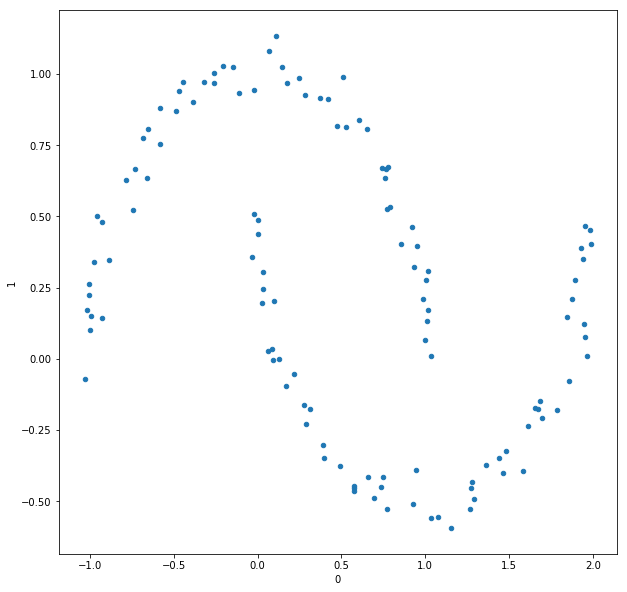

In [542]:
pd.DataFrame(noisy_moons[0]).plot(
    kind='scatter',
    x=0,
    y=1,
    figsize=(10, 10)
);

In [543]:
nmdist_mtx = squareform(pdist(
    X=noisy_moons[0],
    metric='euclidean'
))

In [544]:
nmdist_mtx = nmdist_mtx/nmdist_mtx.max()

In [545]:
nmepsilon_connected_mtx = (nmdist_mtx <= 0.1).astype(int)

link_indexes_npint = np.where(nmepsilon_connected_mtx > 0)

G = nx.Graph()

G.add_nodes_from(list(range(len(nmepsilon_connected_mtx))))

# converting to int; json doesn't like int64 type
link_indexes = ([a.item() for a in link_indexes_npint[0]], [a.item() for a in link_indexes_npint[1]])

edges_list = list(zip(link_indexes[0],link_indexes[1]))

edges_list = list(set(edges_list))

edges_list = [e for e in edges_list if e[0] < e[1]]

G.add_edges_from(edges_list)

nodes = [{'name': str(i)} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]} for u in G.edges()]
with open('noisy_moons_graph.json', 'w') as f:
    json.dump(
        {'nodes': nodes, 'links': links},
        f,
        indent=4,
    )

In [546]:
%%html
<div id="noisy_moons_graph"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [547]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#noisy_moons_graph").select("svg")
  if (svg.empty()) {
    svg = d3.select("#noisy_moons_graph").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("noisy_moons_graph.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.cluster);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

In [548]:
nmepsilon_adjacency = np.zeros(shape=(noisy_moons[0].shape[0], noisy_moons[0].shape[0]))

In [549]:
for (i, j) in edges_list:
    nmepsilon_adjacency[i][j] = 1
    nmepsilon_adjacency[j][i] = 1

In [550]:
nmepsilon_normalized_laplacian = \
np.identity(n=noisy_moons[0].shape[0]) - (np.linalg.inv(np.diag(nmepsilon_adjacency.sum(axis=0)))@nmepsilon_adjacency)

In [551]:
w, v = eig(nmepsilon_normalized_laplacian)

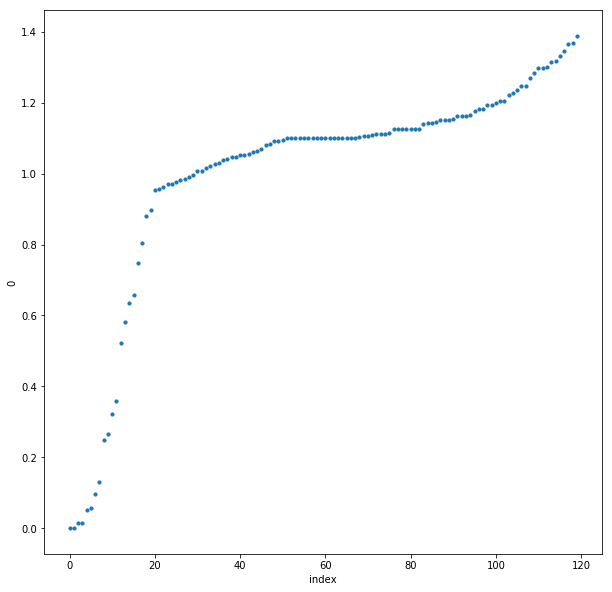

In [552]:
# eigenvalue plot

pd.DataFrame(sorted(w)).reset_index().plot(
    kind='scatter',
    x='index',
    y=0,
    figsize=(10, 10),
    s=10
);

In [553]:
n_clusters = 2

In [554]:
evals_idx_list = [list(w).index(sorted(w)[idx]) for idx in range(n_clusters)]
evals_idx_list

[5, 6]

In [559]:
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42
)

nmepsilon_clusters = kmeans.fit_predict(v[:,evals_idx_list])

In [560]:
nmepsilon_connected_mtx = (nmdist_mtx <= 0.1).astype(int)

link_indexes_npint = np.where(nmepsilon_connected_mtx > 0)

G = nx.Graph()

# G.add_nodes_from(list(range(len(nmepsilon_connected_mtx))))
G.add_nodes_from(list(range(noisy_moons[0].shape[0])))

# converting to int; json doesn't like int64 type
link_indexes = ([a.item() for a in link_indexes_npint[0]], [a.item() for a in link_indexes_npint[1]])

edges_list = list(zip(link_indexes[0],link_indexes[1]))

edges_list = list(set(edges_list))

edges_list = [e for e in edges_list if e[0] < e[1]]

G.add_edges_from(edges_list)

nodes = [{'name': str(i), 'cluster': str(nmepsilon_clusters[i].item())} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]} for u in G.edges()]
with open('noisy_moons_graph_clusters.json', 'w') as f:
    json.dump(
        {'nodes': nodes, 'links': links},
        f,
        indent=4,
    )

In [561]:
%%html
<div id="d3-example11"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [562]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3-example11").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-example11").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("noisy_moons_graph_clusters.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.cluster);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

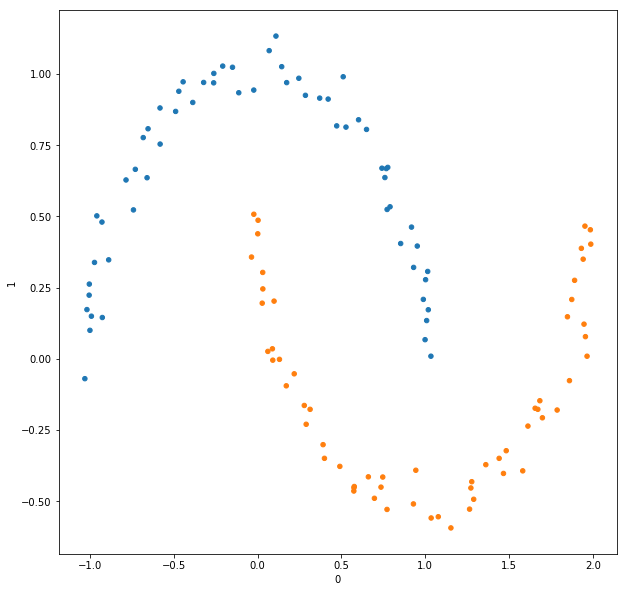

In [574]:
pd.DataFrame(noisy_moons[0]).plot(
    kind='scatter',
    x=0,
    y=1,
    figsize=(10, 10),
    c=['#1f77b4' if x == 0 else '#ff7f0e' for x in  nmepsilon_clusters]
);

# Breast cancer proteomes

## Data cleaning

In [5]:
cancer_proteomes = pd.read_csv('/Users/eric.bunch/Downloads/breastcancerproteomes/77_cancer_proteomes_CPTAC_itraq.csv', header=0, index_col=0)
clinical = pd.read_csv('/Users/eric.bunch/Downloads/breastcancerproteomes/clinical_data_breast_cancer.csv', header=0, index_col=0)
proteins = pd.read_csv('/Users/eric.bunch/Downloads/breastcancerproteomes/PAM50_proteins.csv', header=0)

In [6]:
desc(cancer_proteomes)

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,AN-A04A.05TCGA,BH-A0AV.05TCGA,C8-A12T.06TCGA,A8-A06Z.07TCGA,A2-A0CM.07TCGA,BH-A18U.08TCGA,A2-A0EQ.08TCGA,AR-A0U4.09TCGA,AO-A0J9.10TCGA,AR-A1AP.11TCGA,AN-A0FK.11TCGA,AO-A0J6.11TCGA,A7-A13F.12TCGA,BH-A0E1.12TCGA,A7-A0CE.13TCGA,A2-A0YC.13TCGA,AO-A0JC.14TCGA,A8-A08Z.14TCGA,AR-A0TX.14TCGA,A8-A076.15TCGA,AO-A126.15TCGA,BH-A0C1.16TCGA,A2-A0EY.16TCGA,AR-A1AW.17TCGA,AR-A1AV.17TCGA,C8-A135.17TCGA,A2-A0EV.18TCGA,AN-A0AM.18TCGA,D8-A142.18TCGA,AN-A0FL.19TCGA,BH-A0DG.19TCGA,AR-A0TV.20TCGA,C8-A12Z.20TCGA,AO-A0JJ.20TCGA,AO-A0JE.21TCGA,AN-A0AJ.21TCGA,A7-A0CJ.22TCGA,AO-A12F.22TCGA,A8-A079.23TCGA,A2-A0T3.24TCGA,A2-A0YD.24TCGA,AR-A0TR.25TCGA,AO-A03O.25TCGA,AO-A12E.26TCGA,A8-A06N.26TCGA,A2-A0YG.27TCGA,BH-A18N.27TCGA,AN-A0AL.28TCGA,A2-A0T6.29TCGA,E2-A158.29TCGA,E2-A15A.29TCGA,AO-A0JM.30TCGA,C8-A12V.30TCGA,A2-A0D2.31TCGA,C8-A12U.31TCGA,AR-A1AS.31TCGA,A8-A09G.32TCGA,C8-A131.32TCGA,C8-A134.32TCGA,A2-A0YF.33TCGA,BH-A0DD.33TCGA,BH-A0E9.33TCGA,AR-A0TT.34TCGA,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,0.384588,0.350536,-0.204918,-0.496409,0.683404,-0.265030,-0.912670,-0.033221,0.020007,0.461088,0.973564,0.831132,1.279185,0.762044,-1.123173,0.818824,-0.307267,0.568895,-0.583429,1.873982,0.195877,-0.518366,1.174881,0.578309,-0.759823,1.120502,0.452986,1.501967,0.538596,2.455138,-0.205637,-1.514278,-0.787195,0.757188,0.559777,-0.428181,-1.00124,-1.947792,1.048959,0.583713,0.063779,-1.101675,1.053225,0.264859,0.238547,-0.078202,1.101261,0.323663,0.793976,-1.086529,2.180123,1.395247,0.673905,0.107491,-0.481550,1.222507,-1.523343,2.707250,0.140182,0.311319,-0.692316,1.466665,-0.511421,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,0.371393,0.367405,-0.162418,-0.498509,0.694424,-0.251642,-0.927979,-0.030216,0.011955,0.461088,0.977476,0.856540,1.275167,0.762044,-1.123173,0.814877,-0.307267,0.568895,-0.572549,1.870383,0.195877,-0.510002,1.183209,0.582213,-0.759823,1.137618,0.472590,1.510348,0.542211,2.480137,-0.205637,-1.528285,-0.755941,0.780871,0.563407,-0.406378,-1.00462,-1.952718,1.052257,0.580623,0.093336,-1.108783,1.055948,0.275711,0.249818,-0.068058,1.101261,0.326973,0.818182,-1.095492,2.180123,1.408922,0.688718,0.104164,-0.477890,1.218974,-1.512646,2.733832,0.126054,0.296177,-0.659469,1.482283,-0.526067,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,0.371393,0.367405,-0.166668,-0.496409,0.698098,-0.251642,-0.927979,-0.027212,0.011955,0.461088,0.977476,0.856540,1.275167,0.766384,-1.116861,0.814877,-0.307267,0.568895,-0.567109,1.870383,0.195877,-0.507214,1.183209,0.578309,-0.749114,1.137618,0.472590,1.501967,0.542211,2.480137,-0.205637,-1.528285,-0.755941,0.774104,0.559777,-0.406378,-1.00462,-1.955180,1.052257,0.580623,0.084469,-1.108783,1.055948,0.275711,0.244183,-0.071439,1.097767,0.326973,0.814724,-1.095492,2.180123,1.412341,0.688718,0.107491,-0.481550,1.222507,-1.509972,2.737629,0.133118,0.296177,-0.664161,1.474474,-0.526067,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,0.377990,0.360657,-0.183668,-0.492209,0.687077,-0.251642,-0.931806,

(12553, 85)
gene_symbol        object
gene_name          object
AO-A12D.01TCGA    float64
C8-A131.01TCGA    float64
AO-A12B.01TCGA    float64
BH-A18Q.02TCGA    float64
C8-A130.02TCGA    float64
C8-A138.03TCGA    float64
E2-A154.03TCGA    float64
C8-A12L.04TCGA    float64
A2-A0EX.04TCGA    float64
AO-A12D.05TCGA    float64
AN-A04A.05TCGA    float64
BH-A0AV.05TCGA    float64
C8-A12T.06TCGA    float64
A8-A06Z.07TCGA    float64
A2-A0CM.07TCGA    float64
BH-A18U.08TCGA    float64
A2-A0EQ.08TCGA    float64
AR-A0U4.09TCGA    float64
AO-A0J9.10TCGA    float64
AR-A1AP.11TCGA    float64
AN-A0FK.11TCGA    float64
AO-A0J6.11TCGA    float64
A7-A13F.12TCGA    float64
BH-A0E1.12TCGA    float64
A7-A0CE.13TCGA    float64
A2-A0YC.13TCGA    float64
AO-A0JC.14TCGA    float64
A8-A08Z.14TCGA    float64
                   ...   
AO-A12E.26TCGA    float64
A8-A06N.26TCGA    float64
A2-A0YG.27TCGA    float64
BH-A18N.27TCGA    float64
AN-A0AL.28TCGA    float64
A2-A0T6.29TCGA    float64
E2-A158.29TCGA    float64


In [7]:
desc(clinical)

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,Metastasis-Coded,AJCC Stage,Converted Stage,Survival Data Form,Vital Status,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,Positive,Stage IV,No_Conversion,followup,DECEASED,240,240.0,1,240,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,1,754,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1555,1555.0,1,1555,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1692,1692.0,1,1692,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,Negative,Stage IIIC,No_Conversion,followup,LIVING,133,NaN,0,133,Basal-like,0,-13,5,5,Basal,1,2,2,2


(105, 29)
Gender                                  object
Age at Initial Pathologic Diagnosis      int64
ER Status                               object
PR Status                               object
HER2 Final Status                       object
Tumor                                   object
Tumor--T1 Coded                         object
Node                                    object
Node-Coded                              object
Metastasis                              object
Metastasis-Coded                        object
AJCC Stage                              object
Converted Stage                         object
Survival Data Form                      object
Vital Status                            object
Days to Date of Last Contact             int64
Days to date of Death                  float64
OS event                                 int64
OS Time                                  int64
PAM50 mRNA                              object
SigClust Unsupervised mRNA               int64
Sig

In [8]:
desc(proteins)

,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160


(100, 4)
GeneSymbol         object
RefSeqProteinID    object
Species            object
Gene Name          object
dtype: object


In [9]:
# This code is taken from the example on kaggle for kmeans clustering on this data referenced at the beginning of this notebook

## Drop unused information columns
cancer_proteomes.drop(['gene_symbol','gene_name'],axis=1,inplace=True)

## Change the protein data sample names to a format matching the clinical data set
cancer_proteomes.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
cancer_proteomes = cancer_proteomes.transpose()

## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in cancer_proteomes.index],:]

## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = cancer_proteomes.merge(clinical,left_index=True,right_index=True)

## Change name to make it look nicer in the code!
processed = merged

## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]

## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_numerical_p50 = processed_numerical.iloc[:,processed_numerical.columns.isin(proteins['RefSeqProteinID'])]

## Impute missing values (maybe another method would work better?)
# imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
# imputer = imputer.fit(processed_numerical_p50)
# processed_numerical_p50 = imputer.transform(processed_numerical_p50)

In [10]:
processed_numerical_p50 = processed_numerical_p50.fillna(processed_numerical_p50.median(), axis=0)

In [11]:
processed_numerical_p50.shape
processed_numerical_p50.head()

(80, 43)

,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,NP_061155,NP_001035932,NP_077006,NP_000917,NP_065178,NP_006836,NP_006614,NP_001784,NP_006092,NP_001153651,NP_001159403,NP_000116,NP_004314,NP_060601,NP_005931,NP_003003,NP_113611,NP_002002,NP_004487,NP_008950,NP_114172,NP_001062,NP_001444,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,2.277710,-4.029719,-4.029719,-6.509343,1.906685,2.215260,-1.601524,1.631171,2.013217,-6.395464,0.584219,-4.937078,-0.433346,3.126292,-1.182743,0.286664,0.980958,1.509945,-4.433806,2.549550,2.733226,0.896468,1.576068,-1.292949,3.541400,3.177722,0.001309,-1.792547,-0.830502,-0.538113,2.516489,2.556897,-2.035927
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,2.934943,-5.567372,-5.567372,-5.287953,1.198555,3.264258,2.449287,2.332862,3.606879,-7.124134,-0.853843,-4.153646,-2.417258,-0.604362,2.545753,7.053044,2.921637,3.743262,-6.269245,2.376105,2.781928,6.836827,2.898353,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,1.029442,-0.714133
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,-0.859091,-1.241800,-1.241800,-7.047502,1.961478,0.863101,1.842838,-0.369223,0.266075,-3.055843,-0.836128,-6.308873,-0.686872,0.162743,-2.791774,-5.554936,0.047930,3.388984,0.063239,0.545453,-0.273546,1.460128,-0.174083,-1.410193,0.702364,-1.402538,0.001309,-0.210764,1.934688,-0.538113,0.798041,2.003576,-2.035927
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,-4.632905,-2.608071,-2.608071,-1.266583,1.158737,-2.039549,-1.160160,-1.216172,-1.185366,0.466989,-1.924724,0.649028,-0.488016,-6.134027,0.534203,1.080321,-0.709263,-1.199369,-1.723081,-2.179579,-3.311022,0.139319,0.733046,0.018893,-1.574649,-4.515280,0.001309,-0.210764,2.049328,-0.538113,-0.266769,-3.201798,-7.724769
TCGA-A2-A0EX,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,-2.521730,0.427232,0.415977,1.545287,1.725376,-1.812629,-2.476708,-0.923438,-1.966455,-2.037740,-1.973959,-2.409174,0.115828,-0.882167,0.419729,1.031282,-1.666306,-0.083021,-0.281869,-3.752341,-3.317125,-2.769353,-0.174083,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-2.079011,-3.046991,2.554537,-0.443199


## Nearest neighbors graph

In [615]:
from sklearn.neighbors import NearestNeighbors

nnb = NearestNeighbors(
    n_neighbors=9,
    algorithm='auto',
    metric='correlation',
    p=2
)

nnb.fit(processed_numerical_p50.values)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='correlation',
         metric_params=None, n_jobs=1, n_neighbors=9, p=2, radius=1.0)

In [616]:
def get_kgneighbors_indexes(idx):
    return nnb.kneighbors(processed_numerical_p50.iloc[[idx]])[1][0]

In [617]:
from functools import reduce

knn_edges = reduce(lambda x, y: x+y, [
    [(idx, neighbor_idx.item()) for neighbor_idx in get_kgneighbors_indexes(idx) if idx != neighbor_idx]
    for idx in range(len(processed_numerical_p50))
])

knn_edges_both = [
    e for e in knn_edges if (e[1], e[0]) in knn_edges and e[0] < e[1]
]

G = nx.Graph()

G.add_nodes_from(list(range(len(processed_numerical_p50))))

G.add_edges_from(knn_edges_both)

nodes = [{'name': str(i)} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]} for u in G.edges()]
with open('nneighbors_graph.json', 'w') as f:
    json.dump(
        {'nodes': nodes, 'links': links},
        f,
        indent=4,
    )

In [620]:
%%html
<div id="d3-example3"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [621]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3-example3").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-example3").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("nneighbors_graph.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.club);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

### Eigenvalue decomposition and clustering

In [624]:
from numpy.linalg import eig
from sklearn.cluster import KMeans

In [625]:
knn_adjacency = np.zeros(shape=(len(processed_numerical_p50), len(processed_numerical_p50)))

In [626]:
for (i, j) in knn_edges_both:
    knn_adjacency[i][j] = 1
    knn_adjacency[j][i] = 1

In [627]:
knn_laplacian = np.diag(knn_adjacency.sum(axis=0)) - knn_adjacency

In [628]:
knn_normalized_laplacian = np.identity(n=len(processed_numerical_p50)) - (np.linalg.inv(np.diag(knn_adjacency.sum(axis=0)))@knn_adjacency)

In [629]:
w, v = eig(knn_normalized_laplacian)

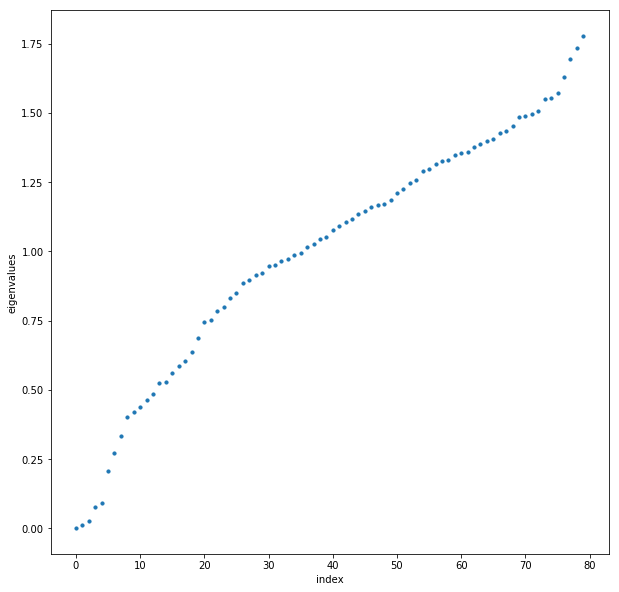

In [630]:
# eigenvalue plot

pd.DataFrame(sorted(w)).reset_index().rename(columns={0: 'eigenvalues'}).plot(
    kind='scatter',
    x='index',
    y='eigenvalues',
    figsize=(10, 10),
    s=10
);

In [631]:
n_clusters = 5

In [632]:
evals_idx_list = [list(w).index(sorted(w)[idx]) for idx in range(n_clusters)]
evals_idx_list

[0, 1, 2, 4, 3]

In [633]:
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42
)

knn_clusters = kmeans.fit_predict(v[:,evals_idx_list])

In [634]:
from functools import reduce

knn_edges = reduce(lambda x, y: x+y, [
    [(idx, neighbor_idx.item()) for neighbor_idx in get_kgneighbors_indexes(idx) if idx != neighbor_idx]
    for idx in range(len(processed_numerical_p50))
])

knn_edges_both = [
    e for e in knn_edges if (e[1], e[0]) in knn_edges and e[0] < e[1]
]

G = nx.Graph()

G.add_nodes_from(list(range(len(processed_numerical_p50))))

G.add_edges_from(knn_edges_both)

nodes = [{'name': str(i), 'cluster': str(knn_clusters[i].item())} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]} for u in G.edges()]
with open('nneighbors_graph_clusters_graph.json', 'w') as f:
    json.dump(
        {'nodes': nodes, 'links': links},
        f,
        indent=4,
    )

In [635]:
%%html
<div id="nneighbors_graph_clusters"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [636]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#nneighbors_graph_clusters").select("svg")
  if (svg.empty()) {
    svg = d3.select("#nneighbors_graph_clusters").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("nneighbors_graph_clusters_graph.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.cluster);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

## Epsilon graph

In [590]:
processed_numerical_p50_normalized = \
(processed_numerical_p50 - processed_numerical_p50.mean()) \
/\
(processed_numerical_p50.max() - processed_numerical_p50.min())

In [591]:
dist_mtx = squareform(pdist(
    X=processed_numerical_p50_normalized.values,
    metric='correlation'
))

In [592]:
dist_mtx = dist_mtx/dist_mtx.max()

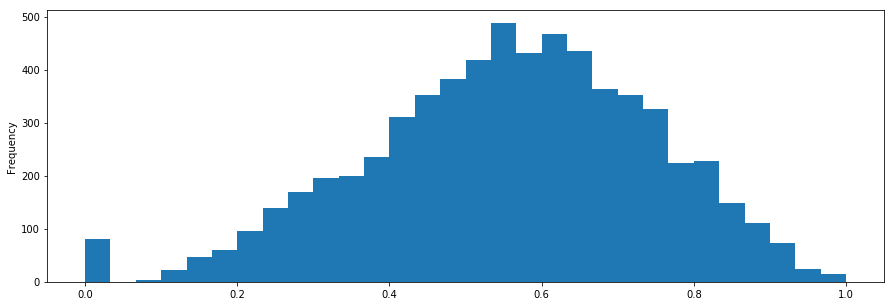

In [593]:
pd.Series(dist_mtx.flatten()).plot(kind='hist', figsize=(15, 5), bins=30);

In [594]:
epsilon_connected_mtx = (dist_mtx <= 0.37).astype(int)

link_indexes_npint = np.where(epsilon_connected_mtx > 0)

G = nx.Graph()

G.add_nodes_from(list(range(len(epsilon_connected_mtx))))

# converting to json doesn't like int64 type

link_indexes = ([a.item() for a in link_indexes_npint[0]], [a.item() for a in link_indexes_npint[1]])

edges_list = list(zip(link_indexes[0],link_indexes[1]))

edges_list = list(set(edges_list))

G.add_edges_from(edges_list)

nodes = [{'name': str(i)} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]} for u in G.edges()]
with open('proteome_epsilon_graph.json', 'w') as f:
    json.dump(
        {'nodes': nodes, 'links': links},
        f,
        indent=4,
    )

In [595]:
%%html
<div id="proteome_epsilon_graph"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [596]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#proteome_epsilon_graph").select("svg")
  if (svg.empty()) {
    svg = d3.select("#proteome_epsilon_graph").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("proteome_epsilon_graph.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.club);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

### Eigenvalue decomposition and clustering

In [597]:
epsilon_adjacency = np.zeros(shape=(len(processed_numerical_p50), len(processed_numerical_p50)))

In [598]:
for (i, j) in edges_list:
    epsilon_adjacency[i][j] = 1
    epsilon_adjacency[j][i] = 1

In [599]:
epsilon_laplacian = np.diag(epsilon_adjacency.sum(axis=0)) - epsilon_adjacency

In [600]:
epsilon_normalized_laplacian = \
np.identity(n=len(processed_numerical_p50)) - (np.linalg.inv(np.diag(epsilon_adjacency.sum(axis=0)))@epsilon_adjacency)

In [601]:
w, v = eig(epsilon_normalized_laplacian)

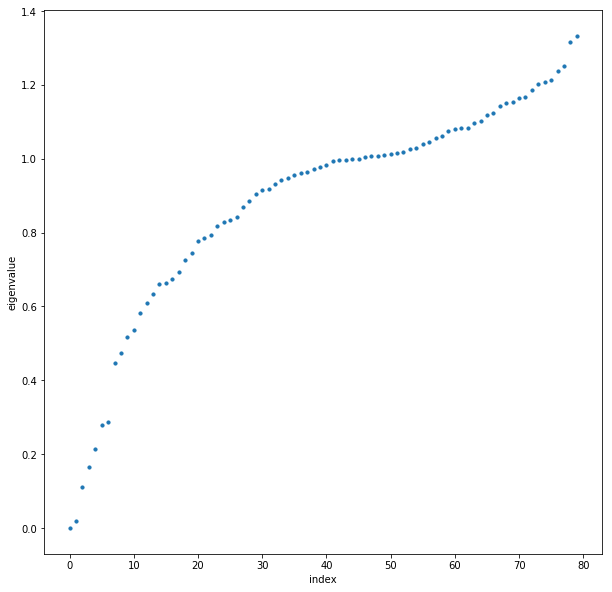

In [608]:
# eigenvalue plot

pd.DataFrame(sorted(w)).reset_index().rename(columns={0: 'eigenvalue'}).plot(
    kind='scatter',
    x='index',
    y='eigenvalue',
    figsize=(10, 10),
    s=10
);

In [609]:
n_clusters = 4

In [610]:
evals_idx_list = [list(w).index(sorted(w)[idx]) for idx in range(n_clusters)]
evals_idx_list

[0, 1, 2, 3]

In [611]:
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42
)

epsilon_clusters = kmeans.fit_predict(v[:,evals_idx_list])

In [612]:
epsilon_connected_mtx = (dist_mtx <= 0.37).astype(int)

link_indexes_npint = np.where(epsilon_connected_mtx > 0)

G = nx.Graph()

G.add_nodes_from(list(range(len(epsilon_connected_mtx))))

# converting to int; json doesn't like int64 type
link_indexes = ([a.item() for a in link_indexes_npint[0]], [a.item() for a in link_indexes_npint[1]])

edges_list = list(zip(link_indexes[0],link_indexes[1]))

edges_list = list(set(edges_list))

edges_list = [e for e in edges_list if e[0] < e[1]]

G.add_edges_from(edges_list)

nodes = [{'name': str(i),'cluster': str(epsilon_clusters[i].item())} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]} for u in G.edges()]
with open('proteome_epsilon_graph_clusters.json', 'w') as f:
    json.dump(
        {'nodes': nodes, 'links': links},
        f,
        indent=4,
    )

In [613]:
%%html
<div id="d3-example5"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [614]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3-example5").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-example5").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("proteome_epsilon_graph_clusters.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.cluster);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>